In [148]:
from urllib.error import HTTPError
from astroquery.skyview import SkyView
from astroquery.mast import Observations
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy.visualization import astropy_mpl_style
from astropy.table import Table
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import pandas as pd

plt.style.use(astropy_mpl_style)

In [149]:
def save_plot_as_image(ax, filename, width=300, height=300):
    """
    Save the plot as an image file with specified dimensions.

    Parameters:
    ----------
    ax : matplotlib.axes.Axes
        The Axes object containing the plot.
    filename : str
        The filename for the saved image.
    width : int
        The width of the image in pixels.
    height : int
        The height of the image in pixels.
    """
    # Temporarily switch to the Agg backend
    original_backend = plt.get_backend()
    plt.switch_backend('Agg')

    # Save the plot as an image file
    image_filename = filename.replace('.fits', '.png')
    fig = ax.figure
    fig.set_size_inches(width / fig.dpi, height / fig.dpi)
    plt.savefig(image_filename, format='png', bbox_inches='tight', pad_inches=0)

    # Switch back to the original backend
    plt.switch_backend(original_backend)
    
    return image_filename

In [150]:
def convert_image_to_fits(image_filename, fits_filename, hdu_name):
    """
    Convert the saved image to FITS format and append it to the FITS file.

    Parameters:
    ----------
    image_filename : str
        The filename of the saved image.
    fits_filename : str
        The filename of the FITS file.
    hdu_name : str
        The name of the HDU to be added to the FITS file.
    """
    # Read the saved image file
    image_data = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to match the FITS dimensions if necessary
    image_data = cv2.resize(image_data, (300, 300), interpolation=cv2.INTER_AREA)
    
    # Create a new ImageHDU for the image data
    image_hdu = fits.ImageHDU(image_data, name=hdu_name)
    
    # Append the ImageHDU to the existing FITS file
    with fits.open(fits_filename, mode='update') as hdul:
        hdul.append(image_hdu)
        hdul.flush()

In [151]:
def getStarData(catalog='II/246', iterations=1, filename='star'):

    # Create a new directory to store the
    if not os.path.exists('data'):
        os.makedirs('data')


    for i in range(iterations):

        filename_str = filename + str(i)
        file_path = 'data/' + filename_str + '.fits'
        attempts = 0

        while attempts < 100:
            try:
                ra = random.uniform(0, 360)
                dec = random.uniform(-90, 90)
                coords = SkyCoord(ra, dec, unit='deg', frame='icrs')

                coords = SkyCoord(ra=172.63903944*u.deg, dec=48.98346557*u.deg, frame='icrs')


                print('SkyView')        #DEBUG


                # Fetch image data from SkyView
                image_list = SkyView.get_images(position=coords, survey=['DSS'], radius=0.25 * u.deg)

                # Extract the image data from the list
                image_hdu = image_list[0][0]
                image = image_list[0][0].data

                # Extract WCS information from image
                wcs = WCS(image_hdu.header)


                print('Vizier')        #DEBUG


                # Fetch star data from Vizier using the 2MASS catalog
                v = Vizier(columns=['*'])
                v.ROW_LIMIT = -1
                catalog_list = v.query_region(coords, radius=0.35 * u.deg, catalog=catalog)
                catalog = catalog_list[0]


                print('Save')        #DEBUG


                # Save the image as a FITS file
                image_hdu = fits.PrimaryHDU(image, header=image_hdu.header)
                hdul = fits.HDUList([image_hdu])
                hdul.writeto(file_path, overwrite=True)

                # return
                break

            except HTTPError as e:
                if e.code == 404:
                    print(f"HTTP Error 404: Not Found. Generating new coordinates and retrying...)")
                    attempts += 1
                else:
                    raise e  # Re-raise the exception if it's not a 404 error
            except Exception as e:
                print(f"An error occurred: {e}. Generating new coordinates and retrying...)")
                attempts += 1
        # raise RuntimeError(f"Failed to fetch and save data after {attempts} attempts.")




        print('Save Catalog')        #DEBUG

        # Save the star catalog
        with fits.open(file_path, mode='update') as hdul:
            # Sanitize the header if necessary
            sanitized_catalog = Table(catalog, meta=sanitize_header(catalog.meta))
            
            # Create a binary table HDU for the star catalog
            star_hdu = fits.BinTableHDU(sanitized_catalog, name='STAR_CATALOG')
            
            # Append the star catalog HDU to the FITS file
            hdul.append(star_hdu)
            hdul.flush()


        coord_range = getCoordRangeFromPixels(wcs)

        # Convert the table to a pandas DataFrame for easier manipulation
        catalog = catalog.to_pandas()


        stars_in_image = getStarsInImage(wcs, catalog, coord_range)
        # print("Stars in image: ", stars_in_image)
        print("Number of cataloged stars in image: ", len(stars_in_image))

        pixel_coords = getPixelCoordsFromStar(stars_in_image[1], wcs)

        # Display the image with the location of the star above circled



        x_dim = wcs.pixel_shape[0] # May need to swap x and y dim! (but I think it's right...)
        y_dim = wcs.pixel_shape[1]

        # Pixel-mask of stars
        pixel_mask = np.zeros((x_dim, y_dim))


        print('Drawing')        #DEBUG


        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection=wcs)
        for star in stars_in_image: 

            pixel_coords = getPixelCoordsFromStar(star, wcs)
            pixel_mask[int(np.floor(pixel_coords[0]))][int(np.floor(pixel_coords[1]))] = 1

            # print('PIXEL COORDS: ', pixel_coords)

            Drawing_colored_circle = plt.Circle(( pixel_coords[0] , pixel_coords[1] ), 0.1, fill=False, edgecolor='Blue')
            ax.add_artist( Drawing_colored_circle )
            ax.set_title(f'{filename}.fits')
            ax.set_xlabel('RA')
            ax.set_ylabel('Dec')
            ax.grid(color='white', ls='dotted')

        # Save the plot as an image file
        image_filename = save_plot_as_image(ax, file_path)
        
        # Convert the saved image to FITS format and append it to the FITS file
        convert_image_to_fits(image_filename, file_path, 'star_overlay')
        


        # Save the pixel mask to the FITS file
        with fits.open(file_path, mode='update') as hdul:
            hdu = fits.ImageHDU(pixel_mask, name='pixel_mask')
            hdul.append(hdu)
            hdul.flush()
        

        # with fits.open(file_path, mode='update') as hdul:
        #     hdu = fits.ImageHDU(star_overlay, name='star_overlay')
        #     hdul.append(star_hdu)
        
        # Display the pixel mask 
        # fig = plt.figure(figsize=(7, 7))
        # ax = fig.add_subplot(111, projection=wcs)


        # ax.set_title(f'{filename}.fits')
        # ax.set_xlabel('RA')
        # ax.set_ylabel('Dec')
        # ax.grid(color='white', ls='dotted')
    
        # ax.imshow(pixel_mask, cmap='gray', origin='lower')



In [152]:
# Ensure the header keywords conform to FITS standards
def sanitize_header(header):
    sanitized_header = {}
    for key, value in header.items():
        if len(key) > 8:
            key = key[:8]  # Truncate to 8 characters
        sanitized_header[key] = value
    return sanitized_header

In [153]:
# Function that takes a wcs object and returns an array of the range of ICRS coordinates in the image
def getCoordRangeFromPixels(wcs):

    x_dim = wcs.pixel_shape[0] # May need to swap x and y dim! (but I think it's right...)
    y_dim = wcs.pixel_shape[1]

    coord_range = {}

    coord_range['lower_left'] = wcs.all_pix2world([0], [0], 1)
    coord_range['lower_right'] = wcs.all_pix2world([x_dim], [0], 1)
    coord_range['upper_left'] = wcs.all_pix2world([0], [y_dim], 1)
    coord_range['upper_right'] = wcs.all_pix2world([x_dim], [y_dim], 1)
    
    return coord_range


In [154]:
# Get all the stars in the image
def getStarsInImage(wcs, catalog, coord_range):

    # NOTE: X Max and min are reversed for some reason.. orientation of image in coord system...?


    x_max = coord_range['lower_left'][0]
    x_min = coord_range['lower_right'][0]

    y_min = coord_range['lower_left'][1]
    y_max = coord_range['upper_left'][1]

    stars_in_image = []

    print("Number of stars in catalog query: ", len(catalog))
    
    for star in catalog.iterrows(): 

        rej = star[1][0]
        dej = star[1][1]

        if rej < x_max and rej > x_min: 

            # print('Star is in x-coords')

            if dej < y_max and dej > y_min: 

                # Then star is within bounds of image! Add it to a list of stars in the image
                # print('Star is in y-coords')

                stars_in_image.append(star)


    return stars_in_image

In [155]:
# Get a star from the catalog and convert is coords to pixel coords
def getPixelCoordsFromStar(star, wcs):

    star_coords = star[1]['_2MASS']

    def parseStarCoords(coords):

        if '-' in coords:

            rej, dej = coords.split('-')
            rej = rej[0:2] + 'h' + rej[2:4] + 'm' + rej[4:6] + '.' + rej[6:] + 's'
            dej = '-' + dej[0:2] + 'd' + dej[2:4] + 'm' + dej[4:6] + '.' + dej[6:] + 's'

        elif '+' in coords:

            rej, dej = coords.split('+')
            rej = rej[0:2] + 'h' + rej[2:4] + 'm' + rej[4:6] + '.' + rej[6:] + 's'
            dej = '+' + dej[0:2] + 'd' + dej[2:4] + 'm' + dej[4:6] + '.' + dej[6:] + 's'

        # print('COORDS:', rej + ' ' + dej)

        return rej + dej
    
    coords = parseStarCoords(star_coords)

    # c = SkyCoord("18h19m02.21s -13d53m28.4s", frame=ICRS)
    c = SkyCoord(coords, frame=ICRS)

    pixel_coords = wcs.world_to_pixel(c)
    # print('Pixel Coords:', pixel_coords)
    return pixel_coords

In [156]:
def extract_star_catalog(file_path):
    """
    Extract the star catalog from the FITS file.

    Parameters:
    ----------
    file_path : str
        The path to the FITS file.

    Returns:
    -------
    catalog : Table
        The star catalog as an astropy Table.
    """
    with fits.open(file_path) as hdul:
        # Locate the STAR_CATALOG HDU
        star_hdu = hdul['STAR_CATALOG']
        
        # Read the star catalog into an astropy Table
        catalog = Table(star_hdu.data)
    
    return catalog

# # Example usage
# file_path = 'data/star0.fits'
# catalog = extract_star_catalog(file_path)

In [157]:
# Display the image with coords overlaid on top
def displayImage(filename):
    file_path = 'data/' + filename
    with fits.open(file_path) as hdul:
        image_hdu = hdul[0]
        wcs = WCS(image_hdu.header)

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection=wcs)

        ax.imshow(image_hdu.data, cmap='gray', origin='lower')
        ax.set_title(filename)
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.grid(color='white', ls='dotted')

        plt.show()

In [158]:
# Display the image
def displayPixelMask(filename):
    file_path = 'data/' + filename
    with fits.open(file_path) as hdul:
        image_hdu = hdul[0]
        wcs = WCS(image_hdu.header)

        pixel_mask = hdul['pixel_mask'].data

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection=wcs)

        ax.imshow(pixel_mask, cmap='gray', origin='lower')
        ax.set_title(filename)
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.grid(color='white', ls='dotted')

        plt.show()

In [159]:
# Display the image with the star overlay
def displayPixelMaskImage(filename, catalog='II/246'):
    """
    Display the image with the star overlay.

    Parameters:
    ----------
    file_path : str
        The path to the FITS file.
    catalog : Table
        The star catalog.
    """
    file_path = 'data/' + filename
    with fits.open(file_path) as hdul:
        image_hdu = hdul[0]
        wcs = WCS(image_hdu.header)

        coord_range = getCoordRangeFromPixels(wcs)

        catalog = extract_star_catalog(file_path)

        # Convert the table to a pandas DataFrame for easier manipulation
        catalog_df = catalog.to_pandas()

        stars_in_image = getStarsInImage(wcs, catalog_df, coord_range)
        print("Number of cataloged stars in image: ", len(stars_in_image))

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection=wcs)

        x_dim = wcs.pixel_shape[0]
        y_dim = wcs.pixel_shape[1]

        # Pixel-mask of stars
        pixel_mask = np.zeros((x_dim, y_dim))

        print('Drawing')  # DEBUG

        for star in stars_in_image:
            pixel_coords = getPixelCoordsFromStar(star, wcs)
            pixel_mask[int(np.floor(pixel_coords[0]))][int(np.floor(pixel_coords[1]))] = 1

            Drawing_colored_circle = plt.Circle((pixel_coords[0], pixel_coords[1]), 0.1, fill=False, edgecolor='Blue')
            ax.add_artist(Drawing_colored_circle)

        ax.set_title(f'{file_path}')
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.grid(color='white', ls='dotted')

        ax.imshow(image_hdu.data, cmap='gray', origin='lower')
        plt.show()

        # # Save the pixel mask to the FITS file
        # with fits.open(file_path, mode='update') as hdul:
        #     hdu = fits.ImageHDU(pixel_mask, name='pixel_mask')
        #     hdul.append(hdu)
        #     hdul.flush()

        # # Display the pixel mask
        # fig = plt.figure(figsize=(7, 7))
        # ax = fig.add_subplot(111, projection=wcs)

        # ax.set_title(filename)
        # ax.set_xlabel('RA')
        # ax.set_ylabel('Dec')
        # ax.grid(color='white', ls='dotted')

        # ax.imshow(pixel_mask, cmap='gray', origin='lower')
        # plt.show()

# Example usage
# displayPixelMaskImage('data/star0.fits', catalog)

In [160]:
getStarData('II/246', 1, 'star')

SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  574
Number of cataloged stars in image:  394
Drawing


/tmp/ipykernel_61625/423886509.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rej = star[1][0]
/tmp/ipykernel_61625/423886509.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dej = star[1][1]
/tmp/ipykernel_61625/1752755034.py:18: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend('Agg')
/tmp/ipykernel_61625/1752755034.py:27: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be 

In [161]:
# Display header info
with fits.open('data/star0.fits') as hdul:
    hdul.info()

Filename: data/star0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     169   (300, 300)   float32   
  1  STAR_CATALOG    1 BinTableHDU     62   574R x 15C   [D, D, 17A, E, E, E, E, E, E, 3A, I, I, 3A, B, B]   
  2  STAR_OVERLAY    1 ImageHDU         8   (300, 300)   uint8   
  3  PIXEL_MASK    1 ImageHDU         8   (300, 300)   float64   


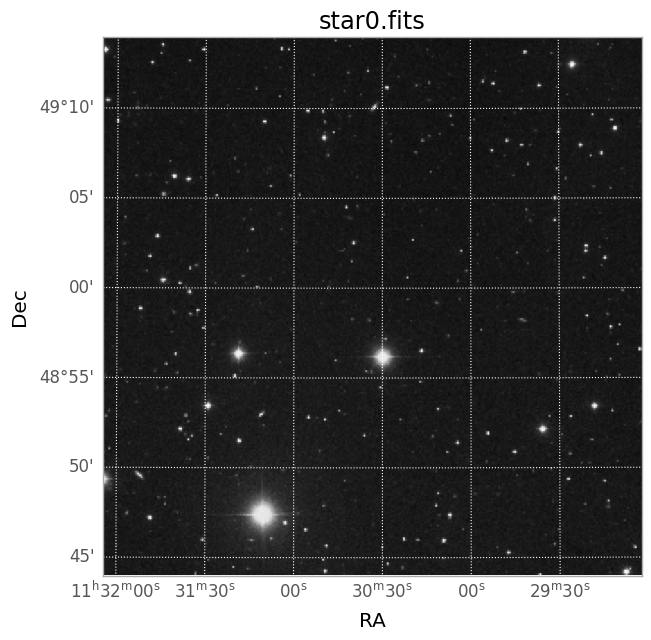

In [162]:
displayImage('star0.fits')

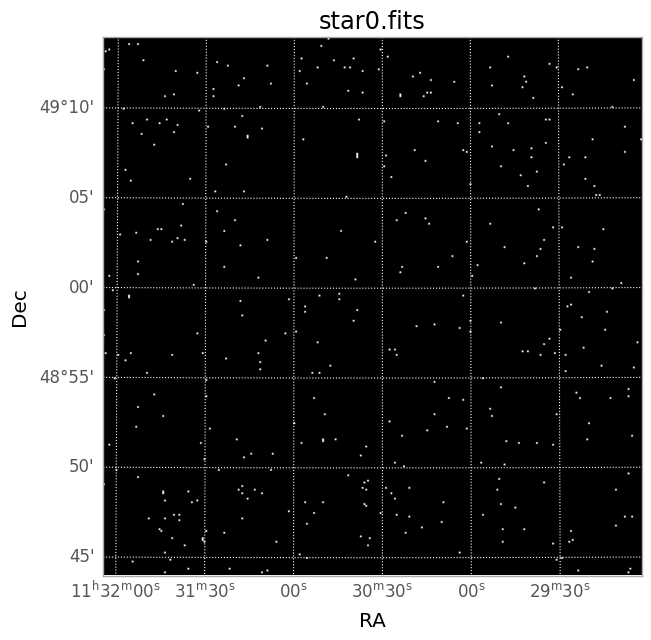

In [163]:
# Display the pixel mask
displayPixelMask('star0.fits')

Number of stars in catalog query:  574
Number of cataloged stars in image:  394
Drawing


/tmp/ipykernel_61625/423886509.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rej = star[1][0]
/tmp/ipykernel_61625/423886509.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dej = star[1][1]


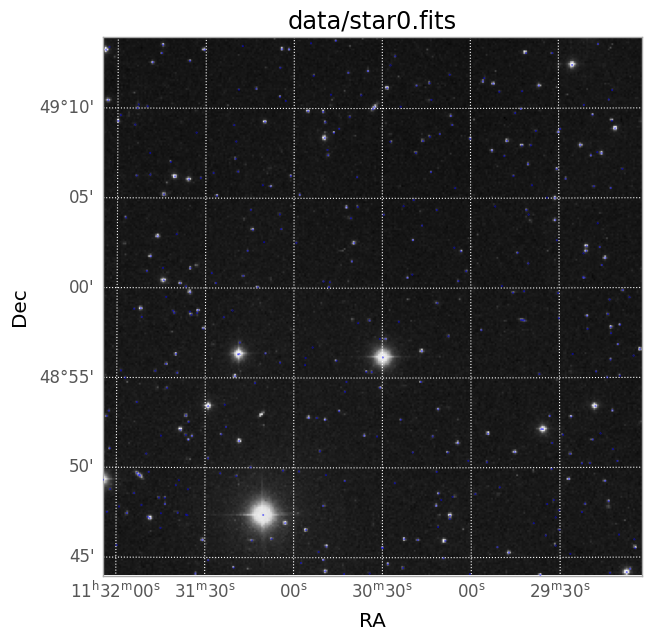

In [164]:
# display the image with the pixel mask overlaid
displayPixelMaskImage('star0.fits')